# KIDNEY DENOISING USING AUTOENCODERS
## APOORVA ARORA (UE214015)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
import zipfile
import cv2

# Define the image dimensions (adjust according to your dataset)
image_height = 384
image_width = 384

def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (image_height, image_width))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (image_height, image_width, 1))

    return img

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import glob

# Set the path to the directory containing the kidney images
dataset_path = "CT Kidney Normal Images/"


# Load the dataset
normal_images = []
file_paths = glob.glob(dataset_path + '*.jpg')

for file_path in file_paths:
    img = process_image(file_path)
    img_array = img_to_array(img)
    normal_images.append(img_array)

# Print the shape of the loaded dataset
print("Loaded dataset shape:", normal_images.shape)

Loaded dataset shape: (258, 384, 384, 1)


In [ ]:
# Adding artificial noise to the data

# Parameters for Gaussian noise
mean = 0  # Controls the spread bias of the noise
std_dev = 0.3  # Lower to reduce noise  and vice versa

# Function to add Gaussian noise to an image
def add_gaussian_noise(image, mean, std_dev):
    noise = np.random.normal(mean, std_dev, image.shape).astype(np.float32)
    noisy_image = np.clip(image + noise, 0.0, 1.0).astype(np.float32)
    return noisy_image

# Add Gaussian noise to each image in the list
noisy_image_list = []
for image in normal_images:
    noisy_image = add_gaussian_noise(image, mean, std_dev)
    noisy_image_list.append(noisy_image)

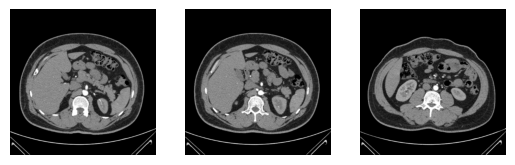

In [ ]:
# Plotting samples from the normal image list
num_samples = 3  # Number of samples to visualize

for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(normal_images[i], cmap='gray')
    plt.axis('off')

plt.show()


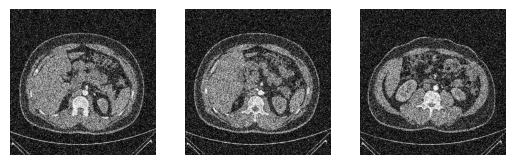

In [ ]:
# Plotting samples from the noisy image list
num_samples = 3

for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(noisy_image_list[i], cmap='gray')
    plt.axis('off')

plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# Convert dataset lists to numpy arrays
normal_images_np = np.array(normal_images)
noisy_images_np = np.array(noisy_image_list)

# Split the dataset into training and testing sets
X_train, X_val, Y_train, Y_val = train_test_split(noisy_images_np, normal_images_np, test_size=0.15, random_state=42)

# Print the shapes of the training and testing sets
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_val.shape)

Training set shape: (219, 384, 384, 1)
Testing set shape: (39, 384, 384, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model

# The autoencoder architecture
input_img = Input(shape=(image_height,image_width, 1))

# Encoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
output_img = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# The autoencoder model
autoencoder = Model(inputs=[input_img], outputs=[output_img])
autoencoder.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])

# Print the model summary
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 384, 384, 1)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 384, 384, 64)      640       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 192, 192, 64)     0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 192, 192, 32)      18464     
                                                                 
 batch_normalization_4 (Batc  (None, 192, 192, 32)     128       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 192, 192, 32)      0   

In [ ]:
# Train the Autoencoder (2hrs)
autoencoder.fit(X_train, Y_train, batch_size=18, epochs=50, validation_data=(X_val, Y_val))

Epoch 1/50
13/13 [==============================] - 206s 15s/step - loss: 0.0814 - mae: 0.2072 - val_loss: 0.1356 - val_mae: 0.3536
Epoch 2/50
13/13 [==============================] - 219s 17s/step - loss: 0.0367 - mae: 0.1460 - val_loss: 0.0847 - val_mae: 0.2697
Epoch 3/50
13/13 [==============================] - 214s 16s/step - loss: 0.0215 - mae: 0.1131 - val_loss: 0.0628 - val_mae: 0.2368
Epoch 4/50
13/13 [==============================] - 213s 16s/step - loss: 0.0143 - mae: 0.0921 - val_loss: 0.0500 - val_mae: 0.1974
Epoch 5/50
13/13 [==============================] - 210s 16s/step - loss: 0.0103 - mae: 0.0771 - val_loss: 0.0494 - val_mae: 0.1816
Epoch 6/50
13/13 [==============================] - 216s 17s/step - loss: 0.0083 - mae: 0.0673 - val_loss: 0.0508 - val_mae: 0.1736
Epoch 7/50
13/13 [==============================] - 217s 17s/step - loss: 0.0075 - mae: 0.0630 - val_loss: 0.0522 - val_mae: 0.1691
Epoch 8/50
13/13 [==============================] - 218s 17s/step - loss: 0.

In [ ]:
# Predicting Values
Y_val = autoencoder.predict(X_val, batch_size=16)

3/3 [==============================] - 4s 1s/step


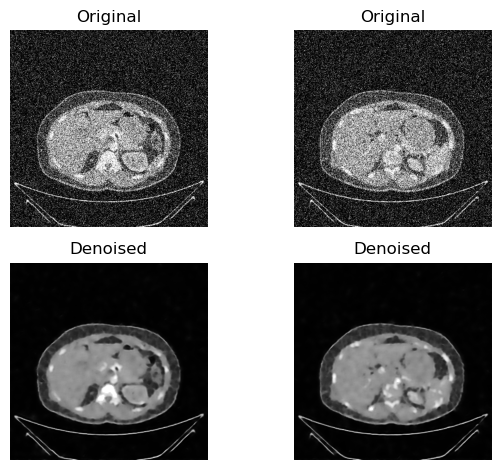

In [ ]:
# Plot the original noisy images and their predicted denoised counterparts side by side
num_samples = 2

for i in range(num_samples):
    # Noisy image
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(X_val[i], cmap='gray')
    plt.axis('off')
    plt.title('Original')

    # Denoised image
    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.imshow(Y_val[i], cmap='gray')
    plt.axis('off')
    plt.title('Denoised')

plt.tight_layout()
plt.show()

In [ ]:
# Exporting the denoised images

import os
import numpy as np
from tensorflow.keras.preprocessing.image import array_to_img

# Set the output directory for the denoised images
output_dir = 'Denoised/'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Export the denoised images
for i, denoised_image in enumerate(Y_val):
    # Reshape the denoised image array to add the channel dimension
    denoised_image = np.squeeze(denoised_image)  # Remove any singleton dimensions
    denoised_image = np.expand_dims(denoised_image, axis=-1)  # Add the channel dimension back

    # Convert the denoised image array to an image
    denoised_img = array_to_img(denoised_image)

    # Save the denoised image to a file
    output_path = os.path.join(output_dir, f'denoised_image_{i}.jpg')
    denoised_img.save(output_path)

    print(f"Exported denoised image {i+1}/{len(Y_val)}")

print("Exporting denoised images completed.")

Exported denoised image 1/39
Exported denoised image 2/39
Exported denoised image 3/39
Exported denoised image 4/39
Exported denoised image 5/39
Exported denoised image 6/39
Exported denoised image 7/39
Exported denoised image 8/39
Exported denoised image 9/39
Exported denoised image 10/39
Exported denoised image 11/39
Exported denoised image 12/39
Exported denoised image 13/39
Exported denoised image 14/39
Exported denoised image 15/39
Exported denoised image 16/39
Exported denoised image 17/39
Exported denoised image 18/39
Exported denoised image 19/39
Exported denoised image 20/39
Exported denoised image 21/39
Exported denoised image 22/39
Exported denoised image 23/39
Exported denoised image 24/39
Exported denoised image 25/39
Exported denoised image 26/39
Exported denoised image 27/39
Exported denoised image 28/39
Exported denoised image 29/39
Exported denoised image 30/39
Exported denoised image 31/39
Exported denoised image 32/39
Exported denoised image 33/39
Exported denoised i

In [ ]:
# Analytics

from skimage.metrics import mean_squared_error, peak_signal_noise_ratio

# Calculate metrics
mse = mean_squared_error(X_val, Y_val)
psnr = peak_signal_noise_ratio(X_val, Y_val)

# Print the metrics
print("Mean Squared Error (MSE):", mse)
print("Peak Signal-to-Noise Ratio (PSNR):", psnr)

Mean Squared Error (MSE): 0.051732080885677253
Peak Signal-to-Noise Ratio (PSNR): 12.862400520569686
